In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from src.classifier import Classifier
from src.data import get_balanced_dataset
from src.utils import (
    plot_accuracy_by_class_barplot,
    plot_fixed_points_similarity_heatmap,
)

In [2]:
# Data
N = 500
P = 10
C = 10
p = 0.2
train_data_dir = "data/train"
test_data_dir = "data/test"

# Model
num_layers = 5
lambda_left = 2.0
lambda_right = 2.0
lambda_x = 5.0
lambda_y = 5.0
J_D = 0.2
sparse_readout = False

# Training
num_epochs = 2
max_steps = 50
lr = 0.003
threshold = 1.5
eval_interval = 1

rng = np.random.default_rng(10)

## Data

In [3]:
train_inputs, train_targets, train_metadata, train_class_prototypes = (
    get_balanced_dataset(
        N,
        P,
        C,
        p,
        train_data_dir,
        None,
        rng,
        shuffle=True,
        load_if_available=True,
        dump=True,
    )
)
eval_inputs, eval_targets, eval_metadata, eval_class_prototypes = get_balanced_dataset(
    N,
    P,
    C,
    p,
    test_data_dir,
    train_class_prototypes,
    rng,
    shuffle=False,
    load_if_available=True,
    dump=True,
)

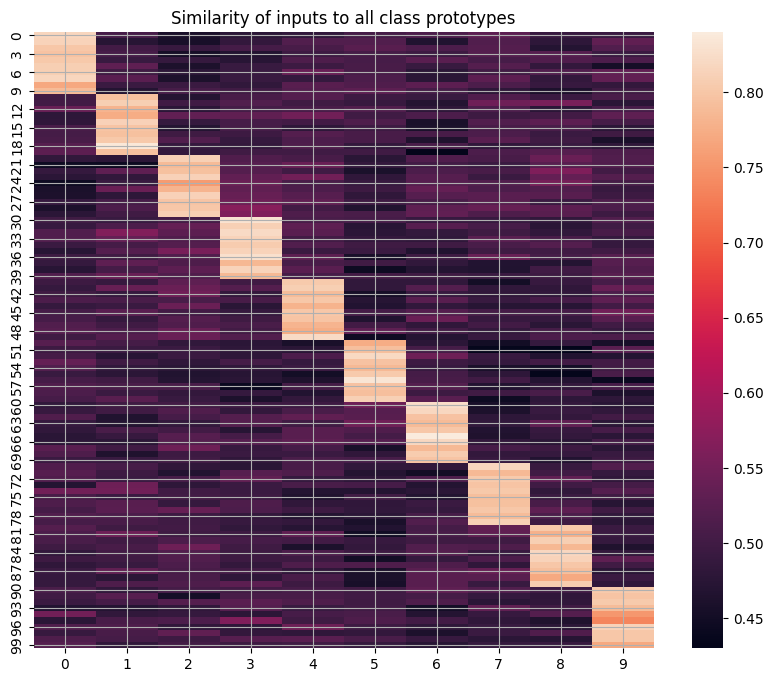

In [4]:
fig, ax = plt.subplots(figsize=(10, 8))

sim_with_all_prototypes = np.zeros((P * C, C))
for i in range(P * C):
    for j in range(C):
        sim_with_all_prototypes[i, j] = np.mean(
            eval_class_prototypes[j] == eval_inputs[i]
        )

sns.heatmap(sim_with_all_prototypes, ax=ax)
ax.set_title("Similarity of inputs to all class prototypes")
ax.grid()

plt.show()

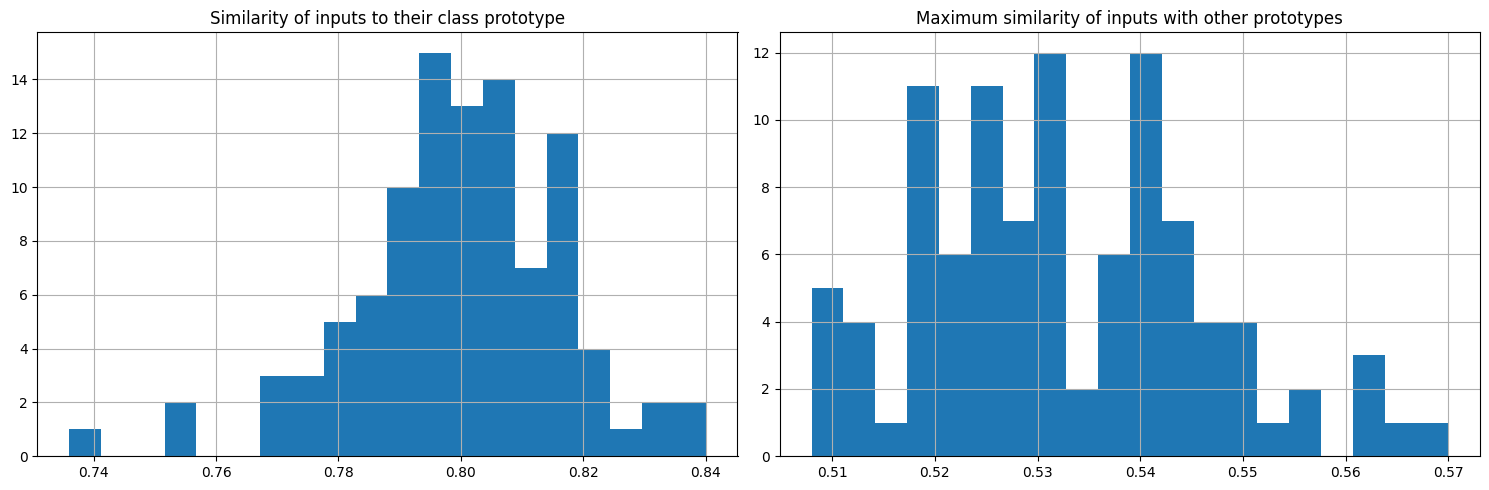

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sim_with_prototype = np.mean(
    eval_class_prototypes[np.argmax(eval_targets, axis=1)] == eval_inputs, axis=1
)
axes[0].hist(sim_with_prototype, bins=20)
axes[0].set_title("Similarity of inputs to their class prototype")
axes[0].grid()

max_sim_with_wrong_prototypes = np.max(
    sim_with_all_prototypes * (1 - eval_targets), axis=1
)
axes[1].hist(max_sim_with_wrong_prototypes, bins=20)
axes[1].set_title("Maximum similarity of inputs with other prototypes")
axes[1].grid()

plt.tight_layout()
plt.show()

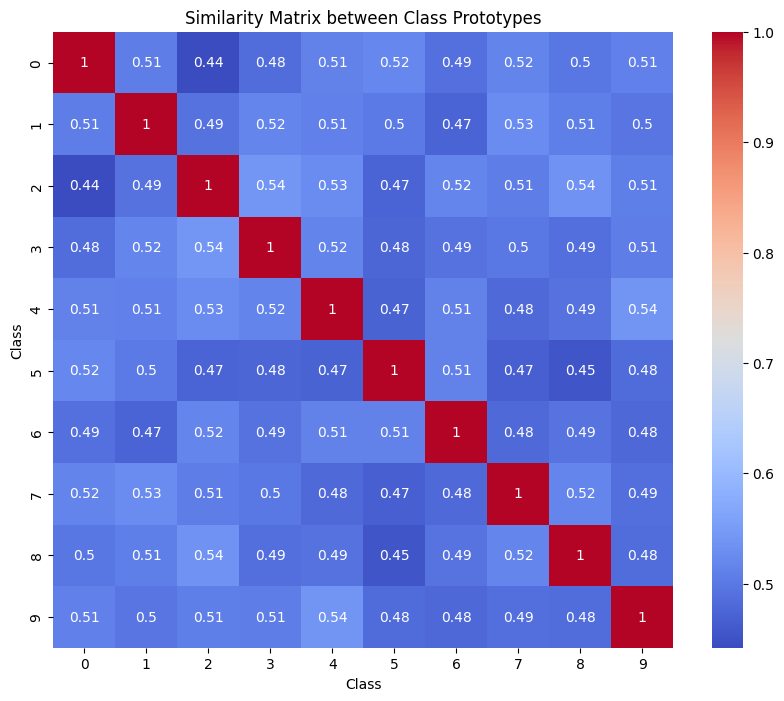

In [6]:
similarity_matrix = np.zeros((C, C))
for i in range(C):
    for j in range(C):
        similarity_matrix[i, j] = np.mean(
            eval_class_prototypes[i] == eval_class_prototypes[j]
        )

plt.figure(figsize=(10, 8))
sns.heatmap(
    similarity_matrix,
    annot=True,
    cmap="coolwarm",
)
plt.title("Similarity Matrix between Class Prototypes")
plt.xlabel("Class")
plt.ylabel("Class")
plt.show()

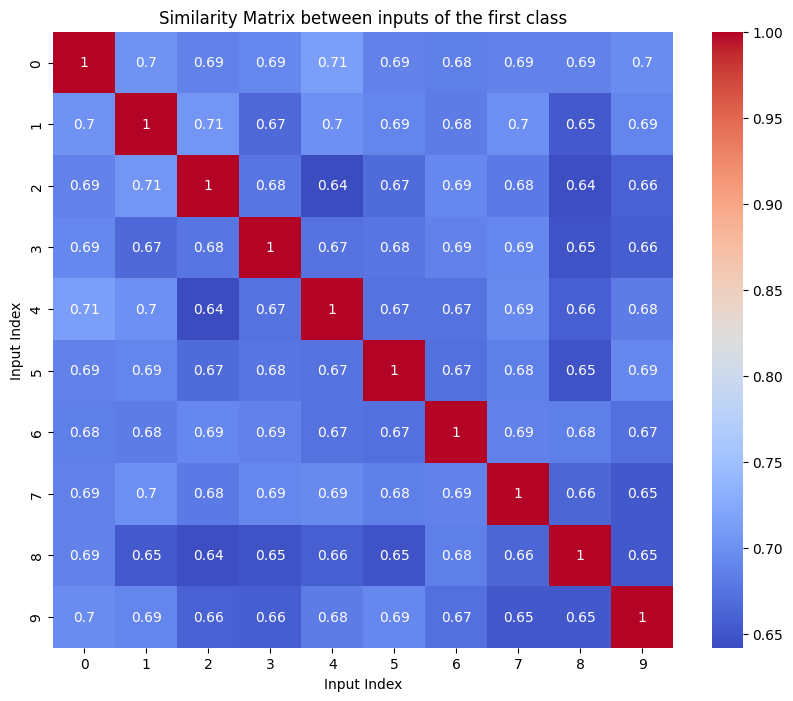

In [7]:
similarity_matrix_first_P = np.zeros((P, P))
for i in range(P):
    for j in range(P):
        similarity_matrix_first_P[i, j] = np.mean(eval_inputs[i] == eval_inputs[j])

plt.figure(figsize=(10, 8))
sns.heatmap(
    similarity_matrix_first_P,
    annot=True,
    cmap="coolwarm",
)
plt.title("Similarity Matrix between inputs of the first class")
plt.xlabel("Input Index")
plt.ylabel("Input Index")
plt.show()

## Model

In [8]:
model = Classifier(
    num_layers,
    N,
    C,
    lambda_left,
    lambda_right,
    lambda_x,
    lambda_y,
    J_D,
    rng,
    sparse_readout=sparse_readout,
)

In [9]:
train_acc_history, eval_acc_history = model.train_loop(
    num_epochs,
    train_inputs,
    train_targets,
    max_steps,
    lr,
    threshold,
    eval_interval,
    eval_inputs,
    eval_targets,
    rng,
)

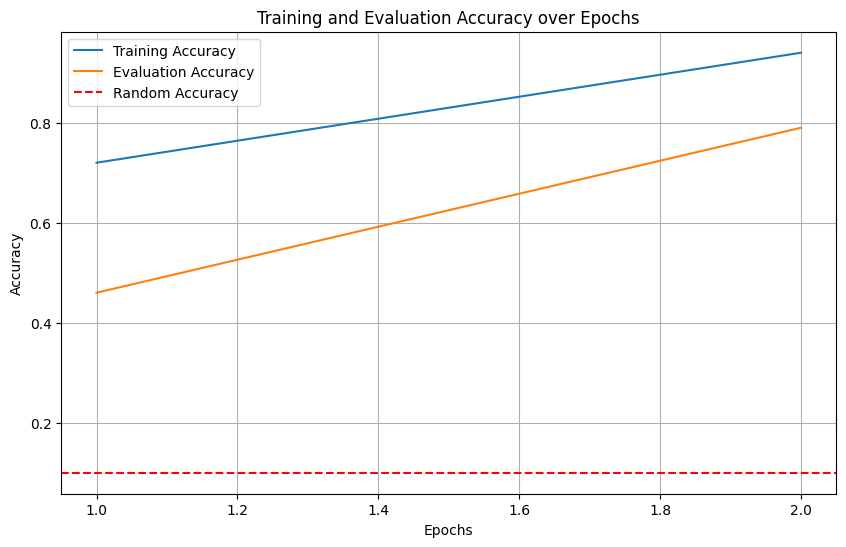

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

epochs = range(1, num_epochs + 1)

ax.plot(epochs, train_acc_history, label="Training Accuracy")
ax.plot(epochs, eval_acc_history, label="Evaluation Accuracy")

random_accuracy = 1 / C
ax.axhline(y=random_accuracy, color="r", linestyle="--", label="Random Accuracy")

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_title("Training and Evaluation Accuracy over Epochs")
ax.legend()
ax.grid()

plt.show()

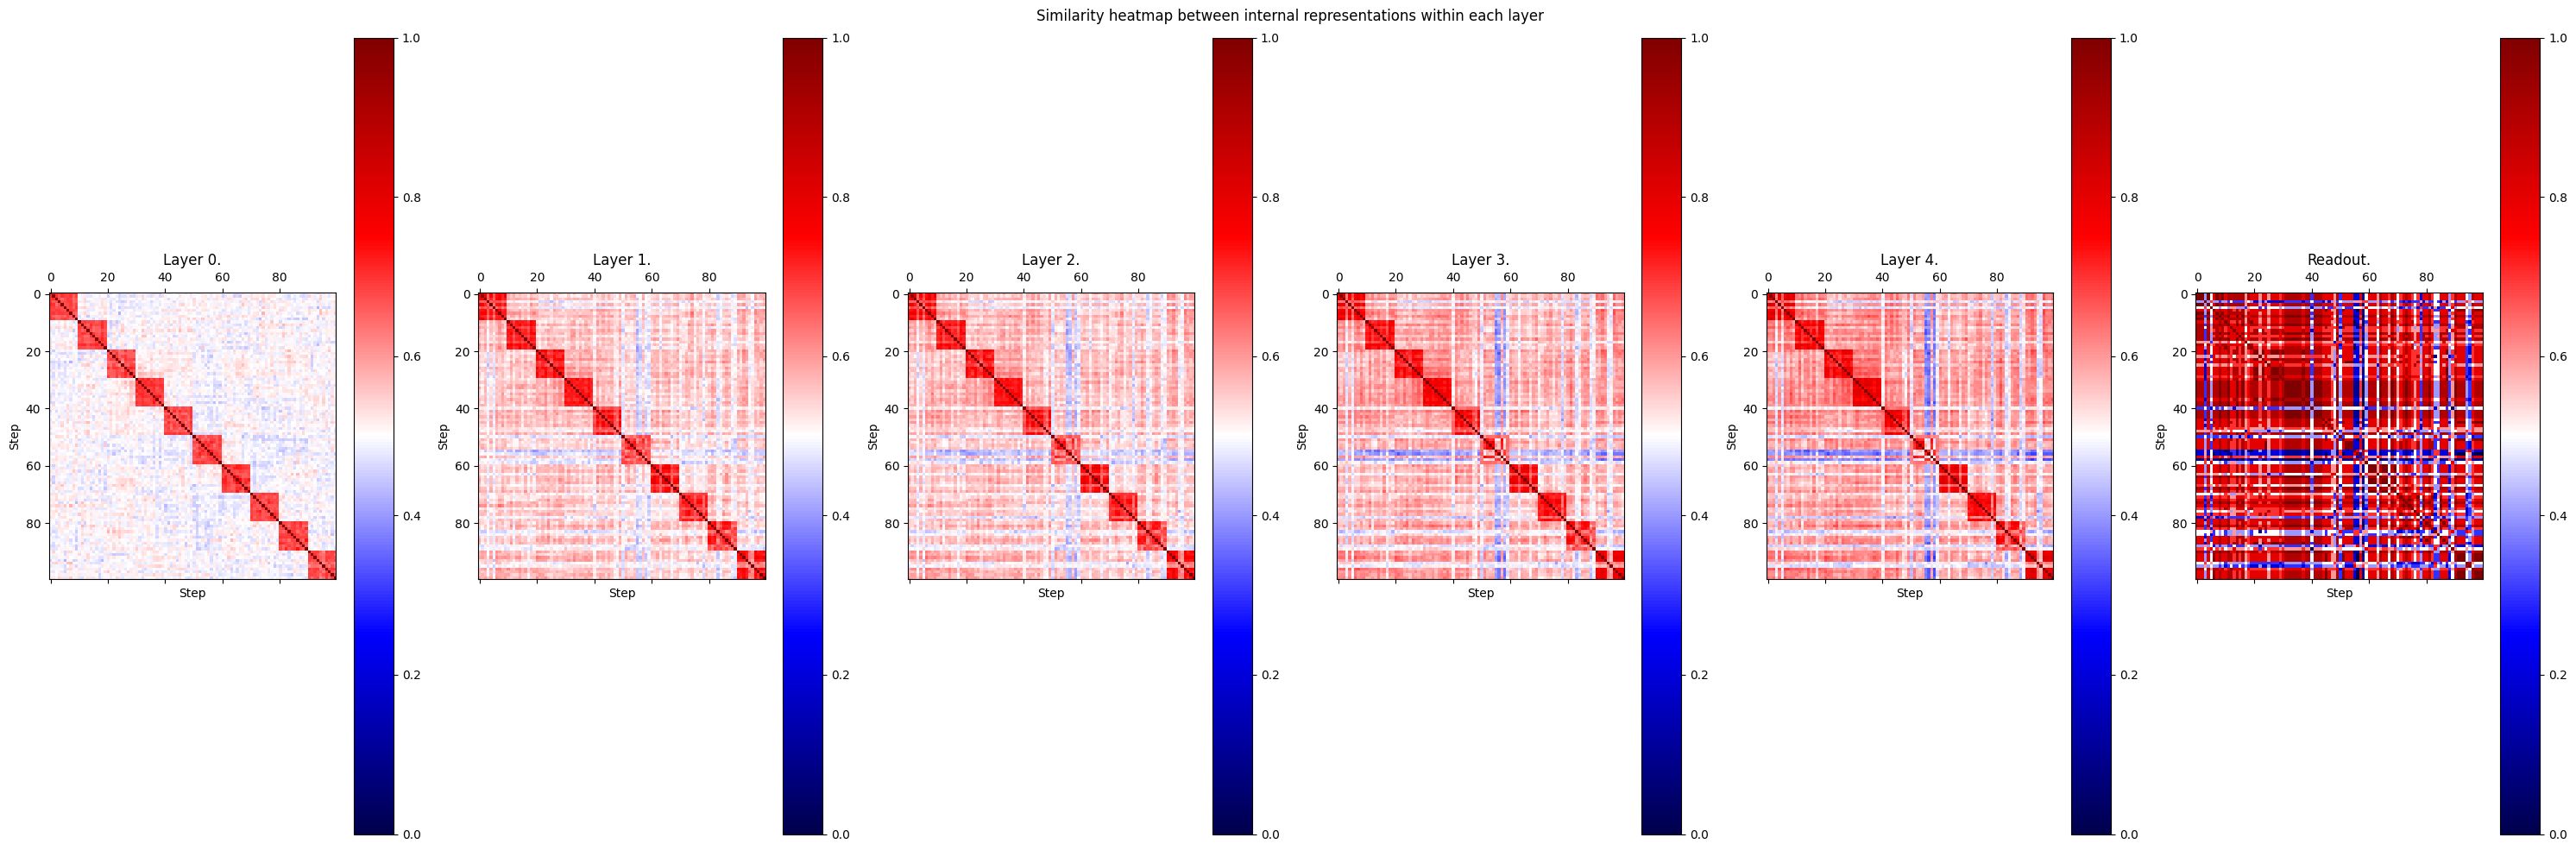

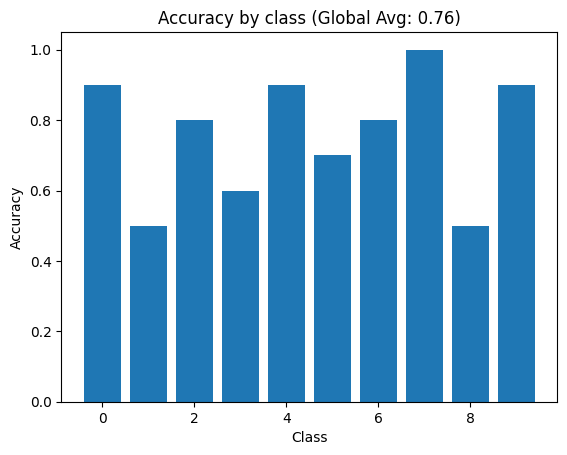

In [ ]:
eval_metrics = model.evaluate(eval_inputs, eval_targets, max_steps, rng)
fig = plot_fixed_points_similarity_heatmap(eval_metrics["fixed_points"])
plt.show()
fig = plot_accuracy_by_class_barplot(eval_metrics["accuracy_by_class"])
plt.show()